# Analyse Exploratoire

In [35]:
# imports l'analyse exploratoire
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Ignorer les warnings
import warnings

## Introduction

On va commencer par ignorer les divers warnings.

In [36]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [38]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Ce csv nous donne des informations sur le comportement habituels des clients d'une épicerie. On peut observer des choses comme les informations personnelles des clients, le revenu annuel, le nombre d'enfants, le nombre d'achat selon les différentes méthodes de ventes etc. 

On a donc un dataset qui semble à première contenir beaucoup d'information sur les clients ce qui nous permettra d'identifier différents clusters par la suite. 

## Traitement et Analyse de la donnée

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Le dataset possède 2240 observations et 28 variables.

### Premières observations

Ce dataset peut être séparé en 4 sets différent de données :

* Information client (id, date de naissance, education etc)
* Produits (Montant dépensé selon les différentes catégories de produits)
* Promotion (la participation aux différentes promotions)
* Canal de vente (l'endroit ou l'achat a été effectué; web, catalogue etc)

On peut également observer à l'aide du '.info()' plus haut qu'il manque des données dans la colonne income. 

La colonne Dt_Customer quant à elle a un datatype 'object' et non 'datetime'.

Il y a des variables catégorielles dans ce dataset qu'il faudra traiter tel quel ou les transformer en valeurs numériques.

In [40]:
df = df.dropna()
print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes :  2216


### Traitement & Analyse

Nous commençons le traitement par la suppression des valeurs nulles. Pour traiter celles-ci nous allons les supprimer directement car elles ne représentent pas une énorme quantité de données. 

In [41]:
import pandas as pd

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)

dates = [i.date() for i in df["Dt_Customer"]]

print("Date du client le plus ancien : ", min(dates))
print("Date du client le plus récent : ", max(dates))

max_date = max(dates)
jours = [(max_date - date).days for date in dates]

df["Client depuis"] = jours


Date du client le plus ancien :  2012-07-30
Date du client le plus récent :  2014-06-29


Ici on a crée une feature à l'aide de la colonne 'Dt_Customer' qui nous permet de savoir depuis combien de jours un client a commencé ses achats au sein de l'épicerie.

In [42]:
print("Nombre de catégories dans la variable Marital_Status : ", df["Marital_Status"].value_counts())

Nombre de catégories dans la variable Marital_Status :  Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [43]:
print("Nombre de catégories dans la variable Education : ", df["Education"].value_counts())

Nombre de catégories dans la variable Education :  Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Ici on peut observer que dans la colonne Marital_Status on a notamment des valeurs qui n'ont pas de sens tel que YOLO ou encore Absurd. On a également des valeurs qui ont la même signification mais qui utilisent deux mots différents 'Alone' & 'Single'. 

Pour la colonne 'Education' il n'y a aucune valeur aberrante à première vue mais il s'agirait de potentiellement combiner certaines de ces valeurs afin de créer des catégories tels que 'Basic', '2nd cycle' & 'graduation' etc.

In [44]:
df["Âge"] = 2024 - df["Year_Birth"]

On récupère dans un premier temps l'âge des clients aujourd'hui afin d'avoir cette information si besoin.

In [45]:
df["Dépenses"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

Ici on va récupérer le montant dépensé par chaque clients peu importe la catégorie de produits.

In [46]:
df["Situation logement"] = df["Marital_Status"].replace({"Married": "Plusieurs", "Together": "Plusieurs", "Divorced": "Seul", "Widow": "Seul", "Single": "Seul", "Absurd": "Seul", "YOLO":"Seul"})

Ici on va se baser sur la colonne 'Marital_Status' afin de déterminer quels sont les clients qui vivent seuls et ceux qui vivent à plusieurs (1 vs 2)

In [47]:
df["Enfants"] = df["Kidhome"] + df["Teenhome"]

Ici on regroupe les deux types d'enfants 'kids' & 'teens' afin d'obtenir le nombre d'enfants total au sein du domicile.

In [48]:
# Replace "Seul" with 1 and "Plusieurs" with 2 in the "Situation logement" column
df["Situation logement"] = df["Situation logement"].replace({"Seul": 1, "Plusieurs": 2})

df["Situation logement"] = pd.to_numeric(df["Situation logement"], errors='coerce')

# Add the numerical values of "Situation logement" to the "Enfants" column
df["Taille foyer"] = df["Situation logement"] + df["Enfants"]

Ici on convertie la nouvelle variable 'Situation logemennt' en variable numérique afin de calculer le nombre de personnes dans le foyer en combinant avec la variable qui indique le nombre d'enfants.

In [49]:
df["Est Parent"] = np.where(df["Enfants"] > 0, 1, 0)

On crée une feature qui nous permettra d'isoler les parents dans le dataset. 

In [50]:
df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

Comme vu plus haut nous allons simplifier notre colonne Education afin de regrouper les niveaux d'études plus ou moins similaires.

In [51]:
df = df.rename(columns={"MntWines": "Vin", "MntFruits": "Fruits", "MntMeatProducts": "Viande", "MntFishProducts": "Poisson", "MntSweetProducts": "Sucré", "MntGoldProds": "Or"})

clean_up = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(clean_up, axis=1)

On drop les colonnes redondantes suite à la création de nos features ainsi que les colonnes qui ne seront pas utiles lors de notre prédiction de données. 

On change également le nom de quelques colonnes afin de faciliter la lecture du dataset.

In [52]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Vin,Fruits,Viande,Poisson,Sucré,Or,...,AcceptedCmp2,Complain,Response,Client depuis,Âge,Dépenses,Situation logement,Enfants,Taille foyer,Est Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2213.000000,2216.000000,2213.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.013538,0.009477,0.150271,353.521209,55.179603,607.075361,1.646182,0.947202,2.592408,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.478262,0.749062,0.906165,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,1.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,180.000000,47.000000,69.000000,1.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,355.500000,54.000000,396.500000,2.000000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,529.000000,65.000000,1048.000000,2.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,699.000000,131.000000,2525.000000,2.000000,3.000000,5.000000,1.000000


On voit qu'il y a des valeurs aberrantes notamment au niveau de 'income' avec un maximum à '666,666' ainsi que pour l'âge avec le client le plus âgé qui aurait 131 ans en 2024.

<Figure size 640x480 with 0 Axes>

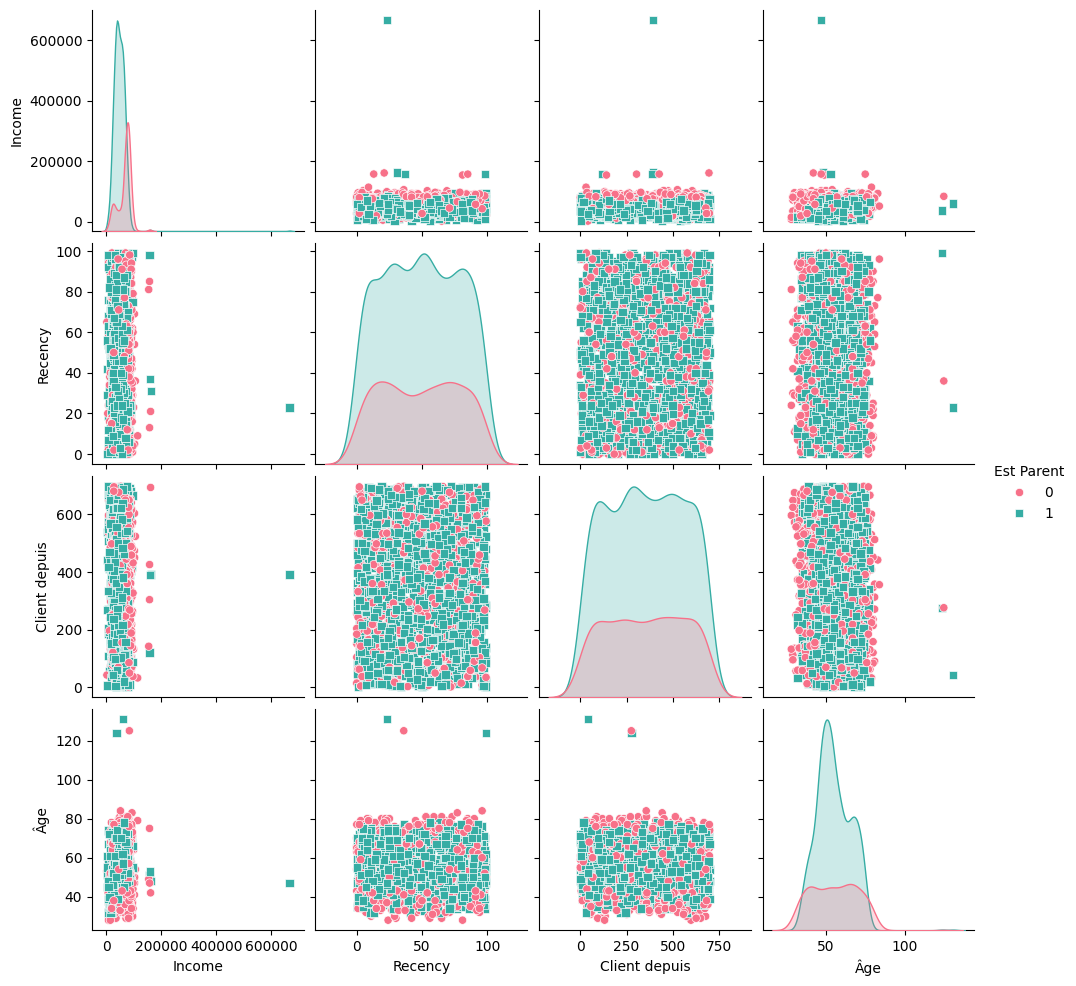

In [53]:
plot = ["Income", "Recency", "Client depuis", "Âge", "Est Parent"]
plt.figure()

sns.pairplot(df[plot], hue="Est Parent", palette="husl", markers=["o", "s"], diag_kind="kde")

plt.show()

On voit bel et bien qu'il y a des outliers pour les variables de l'âge et de l'income. On va supprimer les valeurs aberrantes de ces deux variables en mettant un maximum de 95 ans pour l'âge car le dataset date de quelques années et l'âge est calculé en fonction de notre année actuelle soit 2024. Pour ce qui est du revenu étant donné qu'on observe un seul outlier dans le graphique ci-dessus nous allons mettre un maximum de 650k afin de l'exclure.

In [56]:
df = df[(df["Âge"]<95)]
df = df[(df["Income"]<650000)]

print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes :  2212


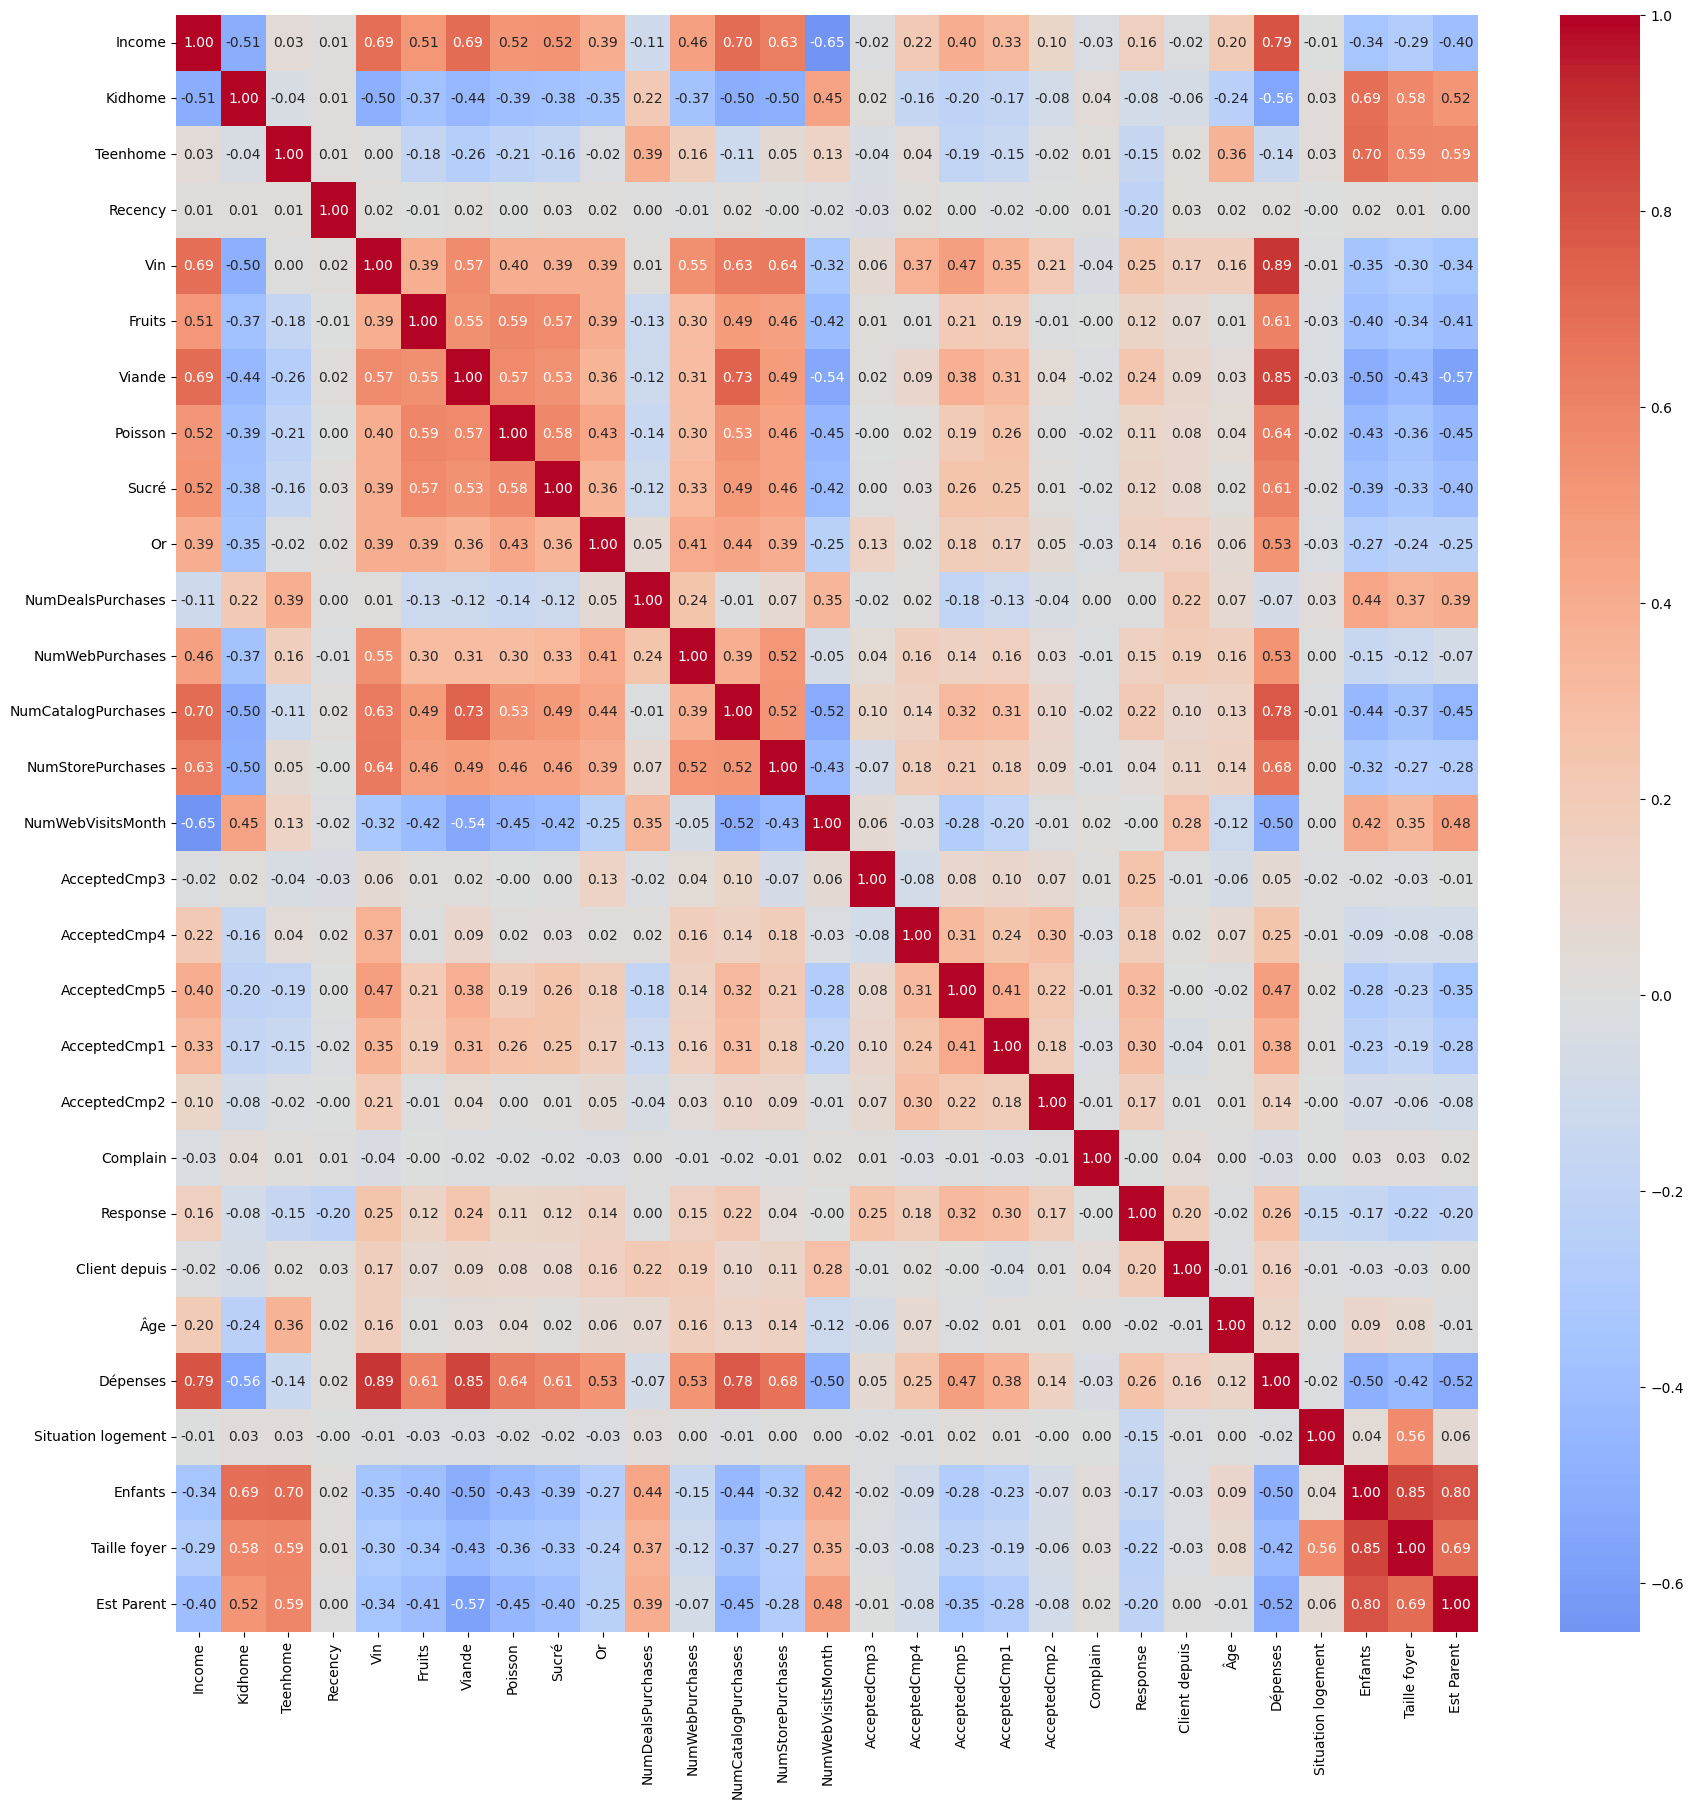

In [71]:
numeric_columns = df.select_dtypes(include=[int, float]).columns
correlation = df[numeric_columns].corr()

plt.figure(figsize=(21, 21))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.show()

On peut voir via cette matrice de corrélations que nous avons de nombreuses corrélations (positives & négatives) au dessus de 0.5 et en dessous de -0.5.

## Algorithmes

### Algorithme 1

### Algorithme 2

### Algorithme 3

## Conclusion